In [1]:
# BÖLÜM 1: KÜTÜPHANELER
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score



file_name = "CDC_Wastewater_Data_for_Influenza_A.csv"
df = pd.read_csv(file_name, low_memory=False)


In [2]:
# BÖLÜM 2: VERİ ÖN İŞLEME VE ÖZELLİK MÜHENDİSLİĞİ (FEATURE ENGINEERING)
print("--- Veri Temizliği ve Özellik Mühendisliğine Başlanıyor ---")

df['sample_collect_date'] = pd.to_datetime(df['sample_collect_date'], errors='coerce')
df['collection_month'] = df['sample_collect_date'].dt.month
df['collection_week'] = df['sample_collect_date'].dt.isocalendar().week.astype(int)
df['collection_dayofweek'] = df['sample_collect_date'].dt.dayofweek

print("Adım (Yeni FE): Döngüsel zaman özellikleri (sin/cos) oluşturuluyor...")
df['month_sin'] = np.sin(2 * np.pi * df['collection_month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['collection_month'] / 12)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['collection_dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['collection_dayofweek'] / 7)

df['flow_rate_missing'] = df['flow_rate'].isnull().astype(int)
flow_median = df['flow_rate'].median()
df['flow_rate'] = df['flow_rate'].fillna(flow_median)

df['pcr_target_flowpop_lin'] = df['pcr_target_flowpop_lin'].fillna(df['pcr_target_flowpop_lin'].median())
df['flowpop_lin_missing'] = df['pcr_target_flowpop_lin'].isnull().astype(int)

df['log_population_served'] = np.log1p(df['population_served'])
df['log_flow_rate'] = np.log1p(df['flow_rate'])

df['influenza_a_detected'] = (df['pcr_target_avg_conc'] > 0).astype(int)
df['log_pcr_target_conc'] = np.log1p(df['pcr_target_avg_conc'])

print("Adım (Yeni FE): Etkileşim özelliği (Kişi Başına Logaritmik Yük) oluşturuluyor...")
df['log_conc_per_capita'] = df['log_pcr_target_conc'] - df['log_population_served']
df['log_conc_per_capita'] = df['log_conc_per_capita'].replace([np.inf, -np.inf], 0)

bins = [0, 20000, 50000, 200000, np.inf]
labels = ['Small', 'Medium', 'Large', 'Very Large']
df['population_group'] = pd.cut(df['population_served'], bins=bins, labels=labels, right=False)

print("Adım (Yeni FE): Kategori Sıklık Kodlaması (Frequency Encoding) oluşturuluyor...")
jurisdiction_counts = df['wwtp_jurisdiction'].value_counts()
df['jurisdiction_freq'] = df['wwtp_jurisdiction'].map(jurisdiction_counts).fillna(0)

columns_to_drop = [
    'inhibition_adjust', 'sample_id', 'date_updated', 'rec_eff_target_name',
    'rec_eff_spike_matrix', 'rec_eff_spike_conc', 'hum_frac_mic_unit',
    'pcr_target_mic_lin', 'hum_frac_mic_conc', 'hum_frac_target_mic',
    'ntc_amplify'
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

df['pasteurized'] = df['pasteurized'].fillna(df['pasteurized'].mode()[0])
df['counties_served'] = df['counties_served'].fillna(df['counties_served'].mode()[0])
df['lod_sewage'] = df['lod_sewage'].fillna(df['lod_sewage'].median())
df['pcr_gene_target_agg'] = df['pcr_gene_target_agg'].fillna(df['pcr_gene_target_agg'].mode()[0])
df['rec_eff_percent'] = np.clip(df['rec_eff_percent'], a_min=None, a_max=100)

df.drop_duplicates(inplace=True)

print("Adım (Encoding): 'population_group' (Small, Medium...) için 'population_group_encoded' (0, 1, 2...) sütunu ekleniyor...")
pop_kategorileri = pd.CategoricalDtype(
    categories=['Small', 'Medium', 'Large', 'Very Large'],
    ordered=True
)
df['population_group'] = df['population_group'].astype(pop_kategorileri)
df['population_group_encoded'] = df['population_group'].cat.codes

print("--- Veri Temizliği ve Özellik Mühendisliğine Tamamlandı ---")


--- Veri Temizliği ve Özellik Mühendisliğine Başlanıyor ---
Adım (Yeni FE): Döngüsel zaman özellikleri (sin/cos) oluşturuluyor...
Adım (Yeni FE): Etkileşim özelliği (Kişi Başına Logaritmik Yük) oluşturuluyor...
Adım (Yeni FE): Kategori Sıklık Kodlaması (Frequency Encoding) oluşturuluyor...
Adım (Encoding): 'population_group' (Small, Medium...) için 'population_group_encoded' (0, 1, 2...) sütunu ekleniyor...
--- Veri Temizliği ve Özellik Mühendisliğine Tamamlandı ---



--- Keşifsel Analizin (EDA) Ana Grafik Çıktıları ---


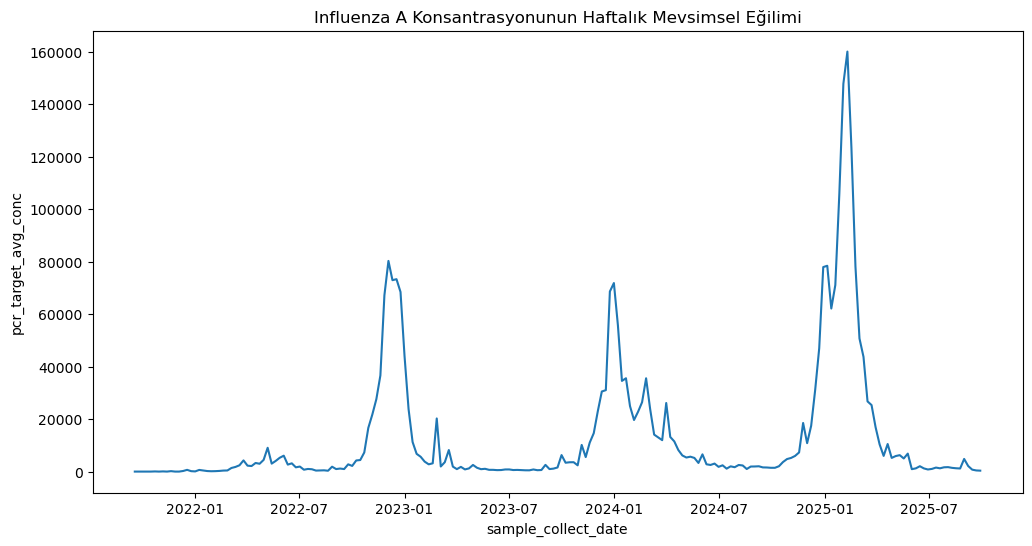

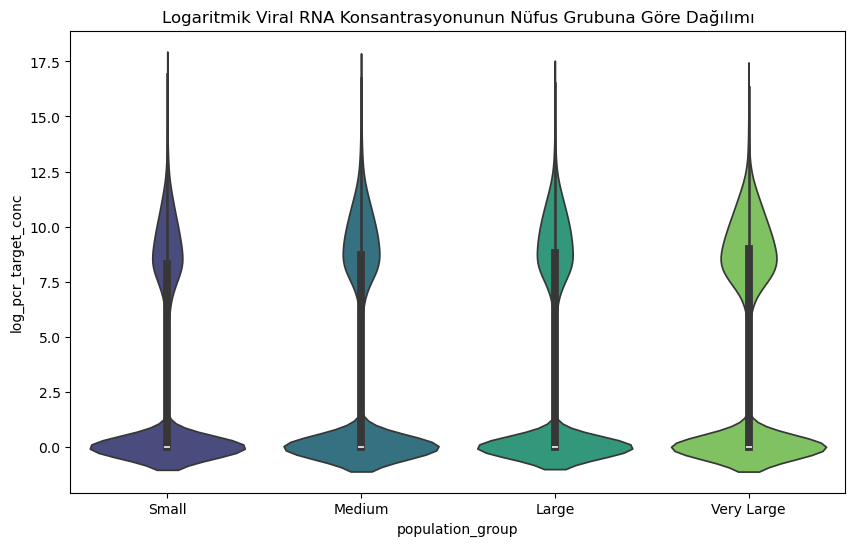


Temizlenmiş ve (YENİ ÖZELLİKLERİ) içeren veri seti başarıyla kaydedildi: temizlenmis_veri_seti_FINAL_koddan_olustu.csv


In [3]:
# BÖLÜM 3: KEŞİFSEL VERİ ANALİZİ (EDA) VE KAYIT
print("\n--- Keşifsel Analizin (EDA) Ana Grafik Çıktıları ---")

plt.figure(figsize=(12, 6))
weekly_avg = df.dropna(subset=['sample_collect_date']).set_index('sample_collect_date')['pcr_target_avg_conc'].resample('W').mean().reset_index()
sns.lineplot(data=weekly_avg, x='sample_collect_date', y='pcr_target_avg_conc')
plt.title('Influenza A Konsantrasyonunun Haftalık Mevsimsel Eğilimi')
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(
    x=df['population_group'].astype(str), y='log_pcr_target_conc', data=df,
    order=['Small', 'Medium', 'Large', 'Very Large'], palette='viridis',
    hue=df['population_group'].astype(str), legend=False
)
plt.title('Logaritmik Viral RNA Konsantrasyonunun Nüfus Grubuna Göre Dağılımı')
plt.show()


output_file_name = "temizlenmis_veri_seti_FINAL_koddan_olustu.csv"
df.to_csv(output_file_name, index=False)
print(f"\nTemizlenmiş ve (YENİ ÖZELLİKLERİ) içeren veri seti başarıyla kaydedildi: {output_file_name}")

In [4]:
# BÖLÜM 4: SINIFLANDIRMA MODELİ HAZIRLIĞI (SPLIT, SCALE, PCA)
features = [
    'collection_week',
    'log_population_served', 'log_flow_rate', 'rec_eff_percent',
    'flow_rate_missing', 'flowpop_lin_missing',
    'population_group_encoded',
    'month_sin', 'month_cos',
    'dayofweek_sin', 'dayofweek_cos',
    'jurisdiction_freq'
]

df_model = df.dropna(subset=features + ['influenza_a_detected', 'log_pcr_target_conc'])

X = df_model[features]

print(f"Model Eğitimi İçin Kullanılan Toplam Satır Sayısı (NaN'ler atıldıktan sonra): {X.shape[0]}")

print("\n--- BÖLUM 1: SINIFLANDIRMA MODELİ EĞİTİMİNE BAŞLANIYOR ---")

y_clf = df_model['influenza_a_detected']

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

print("\nAdım (PCA - Sınıflandırma): Ana Bileşen Analizi uygulanıyor...")
pca_clf = PCA(n_components=0.95, random_state=42)
X_train_clf_pca = pca_clf.fit_transform(X_train_clf_scaled)
X_test_clf_pca = pca_clf.transform(X_test_clf_scaled)
print(f"PCA (Sınıflandırma) {X_train_clf_scaled.shape[1]} adet orijinal özelliği {pca_clf.n_components_} adet ana bileşene indirdi.")

feature_names_clf_pca = [f'Ana Bileşen {i+1}' for i in range(pca_clf.n_components_)]


Model Eğitimi İçin Kullanılan Toplam Satır Sayısı (NaN'ler atıldıktan sonra): 212401

--- BÖLUM 1: SINIFLANDIRMA MODELİ EĞİTİMİNE BAŞLANIYOR ---

Adım (PCA - Sınıflandırma): Ana Bileşen Analizi uygulanıyor...
PCA (Sınıflandırma) 12 adet orijinal özelliği 9 adet ana bileşene indirdi.



--- MODEL 1.1 SONUÇLARI (SGD Sınıflandırıcısı - Ayarlanmış Parametreler ile) ---
Model Doğruluğu (Accuracy): 0.7511
Sınıflandırma Raporu:
               precision    recall  f1-score   support

Grip Yok (0)       0.80      0.77      0.78     24632
Grip Var (1)       0.69      0.73      0.71     17849

    accuracy                           0.75     42481
   macro avg       0.75      0.75      0.75     42481
weighted avg       0.75      0.75      0.75     42481

Model 1.1 - Karmaşıklık Matrisi (Metin):
 [[18904  5728]
 [ 4847 13002]]


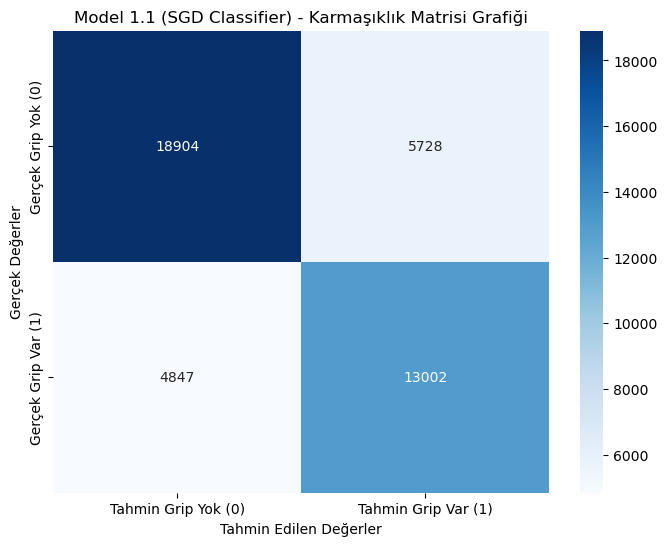


--- PCA Bileşenlerinin Yorumlanması (Sınıflandırma Modeli 1.1) ---
Grafikteki 'Ana Bileşenlerin' (PC) hangi orijinal özellikleri temsil ettiğini gösteren ana yükler (loadings):

Ana Bileşen 1:
  En çok etkileyen 3 özellik: ['log_population_served', 'population_group_encoded', 'log_flow_rate']

Ana Bileşen 2:
  En çok etkileyen 3 özellik: ['collection_week', 'month_sin', 'rec_eff_percent']

Ana Bileşen 3:
  En çok etkileyen 3 özellik: ['rec_eff_percent', 'flow_rate_missing', 'month_sin']

Ana Bileşen 4:
  En çok etkileyen 3 özellik: ['dayofweek_sin', 'dayofweek_cos', 'rec_eff_percent']

Ana Bileşen 5:
  En çok etkileyen 3 özellik: ['month_cos', 'month_sin', 'jurisdiction_freq']

Ana Bileşen 6:
  En çok etkileyen 3 özellik: ['jurisdiction_freq', 'flow_rate_missing', 'dayofweek_cos']

Ana Bileşen 7:
  En çok etkileyen 3 özellik: ['dayofweek_cos', 'dayofweek_sin', 'jurisdiction_freq']

Ana Bileşen 8:
  En çok etkileyen 3 özellik: ['rec_eff_percent', 'flow_rate_missing', 'log_flow_rate']



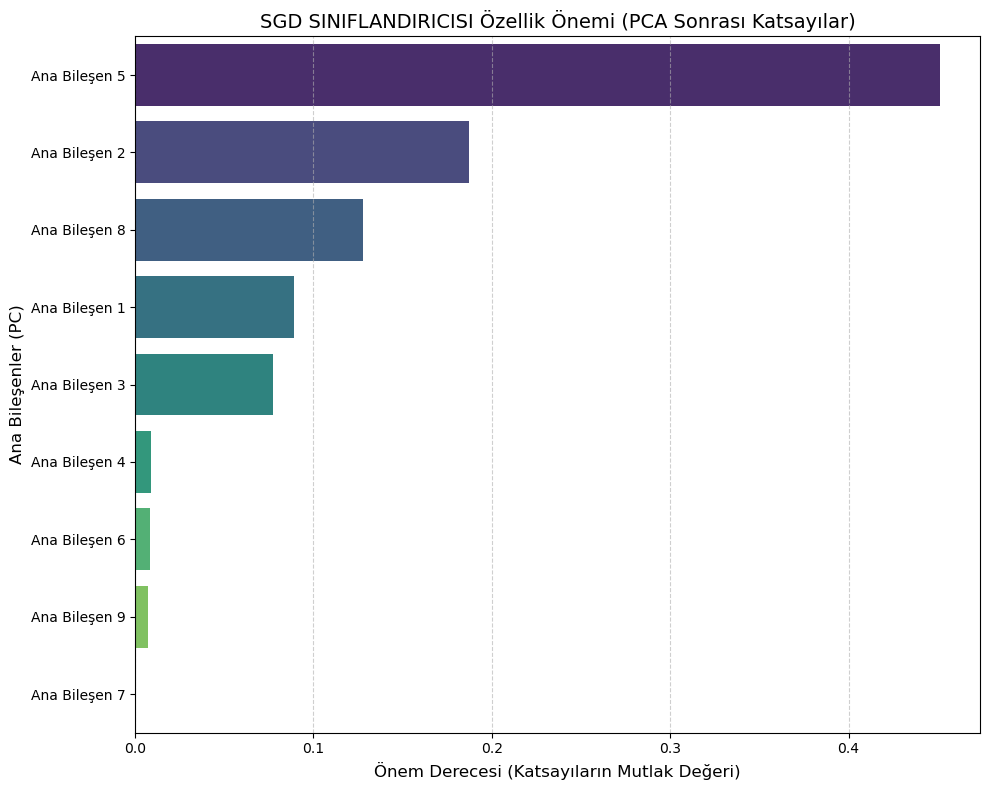


--- MODEL 1.2 SONUÇLARI (Karar Ağacı Sınıflandırıcısı - PCA ile) ---
Model Doğruluğu (Accuracy): 0.7492
Sınıflandırma Raporu:
               precision    recall  f1-score   support

Grip Yok (0)       0.80      0.76      0.78     24632
Grip Var (1)       0.69      0.74      0.71     17849

    accuracy                           0.75     42481
   macro avg       0.74      0.75      0.75     42481
weighted avg       0.75      0.75      0.75     42481

Model 1.2 - Karmaşıklık Matrisi (Metin):
 [[18604  6028]
 [ 4627 13222]]


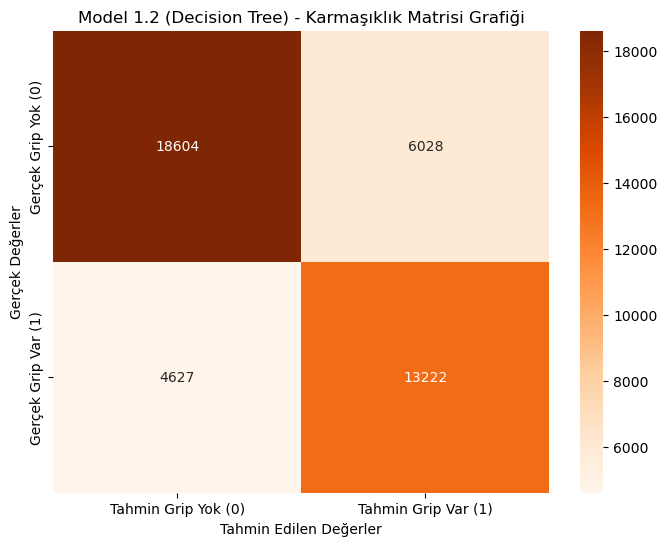

In [5]:
# BÖLÜM 5: SINIFLANDIRMA MODELLERİ (SGD ve DT - PCA İLE)
print("\n--- MODEL 1.1 SONUÇLARI (SGD Sınıflandırıcısı - Ayarlanmış Parametreler ile) ---")

model_sgd_clf = SGDClassifier(
    random_state=60,
    class_weight='balanced',
    loss='modified_huber',
    penalty='elasticnet',
    l1_ratio=0.15,
    alpha=0.001,
    n_jobs=-1
)
model_sgd_clf.fit(X_train_clf_pca, y_train_clf)
y_pred_sgd_clf = model_sgd_clf.predict(X_test_clf_pca)

print(f"Model Doğruluğu (Accuracy): {accuracy_score(y_test_clf, y_pred_sgd_clf):.4f}")
print("Sınıflandırma Raporu:\n", classification_report(y_test_clf, y_pred_sgd_clf, target_names=['Grip Yok (0)', 'Grip Var (1)']))

cm_sgd = confusion_matrix(y_test_clf, y_pred_sgd_clf)
print("Model 1.1 - Karmaşıklık Matrisi (Metin):\n", cm_sgd)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_sgd, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Tahmin Grip Yok (0)', 'Tahmin Grip Var (1)'], 
            yticklabels=['Gerçek Grip Yok (0)', 'Gerçek Grip Var (1)'])
plt.title('Model 1.1 (SGD Classifier) - Karmaşıklık Matrisi Grafiği')
plt.ylabel('Gerçek Değerler')
plt.xlabel('Tahmin Edilen Değerler')
plt.show()


#  PCA Bileşen Yorumlaması (Sınıflandırma) 
print("\n--- PCA Bileşenlerinin Yorumlanması (Sınıflandırma Modeli 1.1) ---")
print("Grafikteki 'Ana Bileşenlerin' (PC) hangi orijinal özellikleri temsil ettiğini gösteren ana yükler (loadings):")
loadings_clf = pca_clf.components_

for i, component in enumerate(feature_names_clf_pca):
    weights = loadings_clf[i]
    feature_weights = pd.Series(weights, index=features)
    sorted_weights = feature_weights.abs().sort_values(ascending=False)
    top_features = sorted_weights.head(3).index
    
    print(f"\n{component}:")
    print(f"  En çok etkileyen 3 özellik: {list(top_features)}")
print("----------------------------------------------------------")

# SGD Sınıflandırıcı Özellik Önemi Grafiği (PCA ile)
print("\nAdım (Grafik): SGD Sınıflandırıcı Özellik Önemi (Katsayılar) gösteriliyor...")
feature_importances_sgd = np.abs(model_sgd_clf.coef_[0])
importance_df_sgd = pd.DataFrame({
    'Feature': feature_names_clf_pca,
    'Importance': feature_importances_sgd
}).sort_values(by='Importance', ascending=False)
top_features_sgd = importance_df_sgd.head(pca_clf.n_components_)

plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance', y='Feature', data=top_features_sgd,
    palette='viridis',
    hue='Feature', legend=False
)
plt.title('SGD SINIFLANDIRICISI Özellik Önemi (PCA Sonrası Katsayılar)', fontsize=14)
plt.xlabel('Önem Derecesi (Katsayıların Mutlak Değeri)', fontsize=12)
plt.ylabel('Ana Bileşenler (PC)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


print("\n--- MODEL 1.2 SONUÇLARI (Karar Ağacı Sınıflandırıcısı - PCA ile) ---")
model_dt_clf = DecisionTreeClassifier(random_state=42, class_weight='balanced',max_depth=5, min_samples_split=20)
model_dt_clf.fit(X_train_clf_pca, y_train_clf)
y_pred_dt_clf = model_dt_clf.predict(X_test_clf_pca)
print(f"Model Doğruluğu (Accuracy): {accuracy_score(y_test_clf, y_pred_dt_clf):.4f}")
print("Sınıflandırma Raporu:\n", classification_report(y_test_clf, y_pred_dt_clf, target_names=['Grip Yok (0)', 'Grip Var (1)']))

cm_dt = confusion_matrix(y_test_clf, y_pred_dt_clf)
print("Model 1.2 - Karmaşıklık Matrisi (Metin):\n", cm_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Tahmin Grip Yok (0)', 'Tahmin Grip Var (1)'], 
            yticklabels=['Gerçek Grip Yok (0)', 'Gerçek Grip Var (1)'])
plt.title('Model 1.2 (Decision Tree) - Karmaşıklık Matrisi Grafiği')
plt.ylabel('Gerçek Değerler')
plt.xlabel('Tahmin Edilen Değerler')
plt.show()

In [6]:
# --- EKSİK OLAN VERİ HAZIRLAMA KISMI (Bunu Model 2.4'ten önce çalıştır) ---

print("\n--- BÖLÜM 2: REGRESYON MODELİ EĞİTİMİNE BAŞLANIYOR ---")
y_reg = df_model['log_pcr_target_conc']

# Veriyi bölme (Train/Test)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

# Ölçekleme (Scaling) - Hatanın sebebi bu kısmın eksik olmasıydı
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

print("Regresyon verileri hazırlandı!")


--- BÖLÜM 2: REGRESYON MODELİ EĞİTİMİNE BAŞLANIYOR ---
Regresyon verileri hazırlandı!


In [7]:
print("\n--- MODEL 1.4 SONUÇLARI (SGD Sınıflandırıcısı - ORİJİNAL ÖZELLİKLER ile) ---")
# PCA uygulanmamış, sadece ölçeklenmiş veriyi kullanıyoruz
model_sgd_clf_original = SGDClassifier(
    random_state=60, class_weight='balanced', loss='modified_huber',
    penalty='elasticnet', l1_ratio=0.15, alpha=0.001, n_jobs=-1
)
model_sgd_clf_original.fit(X_train_clf_scaled, y_train_clf)
y_pred_sgd_clf_orig = model_sgd_clf_original.predict(X_test_clf_scaled)

print(f"Model Doğruluğu (Accuracy): {accuracy_score(y_test_clf, y_pred_sgd_clf_orig):.4f}")


print("\n--- MODEL 2.4 SONUÇLARI (SGD Regresörü - ORİJİNAL ÖZELLİKLER ile) ---")
# PCA uygulanmamış, sadece ölçeklenmiş veriyi kullanıyoruz
model_sgd_reg_original = SGDRegressor(random_state=60) 
model_sgd_reg_original.fit(X_train_reg_scaled, y_train_reg)
y_pred_sgd_reg_orig = model_sgd_reg_original.predict(X_test_reg_scaled)

print(f"Model R-Kare (R²) Skoru: {r2_score(y_test_reg, y_pred_sgd_reg_orig):.4f}")


--- MODEL 1.4 SONUÇLARI (SGD Sınıflandırıcısı - ORİJİNAL ÖZELLİKLER ile) ---
Model Doğruluğu (Accuracy): 0.7472

--- MODEL 2.4 SONUÇLARI (SGD Regresörü - ORİJİNAL ÖZELLİKLER ile) ---
Model R-Kare (R²) Skoru: 0.3291



--- MODEL 1.3 SONUÇLARI (Karar Ağacı Sınıflandırıcısı - ORİJİNAL ÖZELLİKLER ile) ---
NOT: Bu model, PCA'dan önceki durumu görmek için PCA UYGULANMAMIŞ verilerle eğitilmiştir.
Model Doğruluğu (Accuracy): 0.7341
Sınıflandırma Raporu:
               precision    recall  f1-score   support

Grip Yok (0)       0.77      0.76      0.77     24632
Grip Var (1)       0.68      0.69      0.69     17849

    accuracy                           0.73     42481
   macro avg       0.73      0.73      0.73     42481
weighted avg       0.73      0.73      0.73     42481


Adım (Grafik): Karar Ağacı Sınıflandırıcı (Orijinal) Özellik Önemi gösteriliyor...


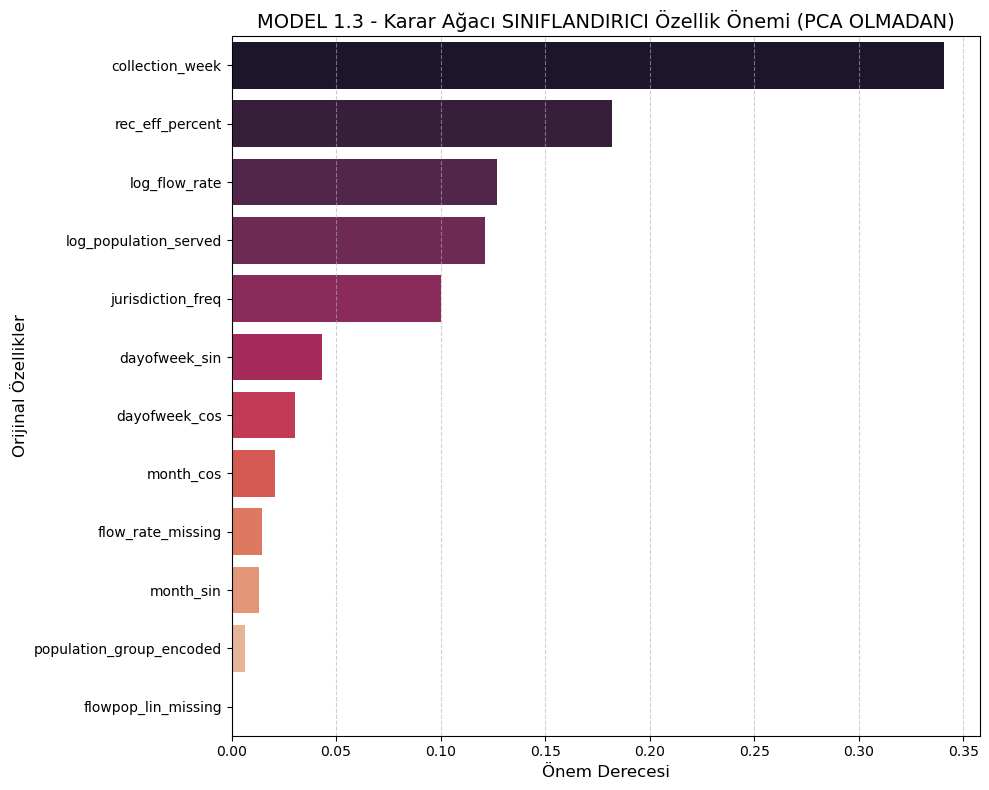

In [8]:
# BÖLÜM 6: SINIFLANDIRMA MODELİ 1.3 (PCA OLMADAN - KARŞILAŞTIRMA)
print("\n--- MODEL 1.3 SONUÇLARI (Karar Ağacı Sınıflandırıcısı - ORİJİNAL ÖZELLİKLER ile) ---")
print("NOT: Bu model, PCA'dan önceki durumu görmek için PCA UYGULANMAMIŞ verilerle eğitilmiştir.")


model_dt_clf_original = DecisionTreeClassifier(random_state=42, class_weight='balanced')
model_dt_clf_original.fit(X_train_clf_scaled, y_train_clf)
y_pred_dt_clf_original = model_dt_clf_original.predict(X_test_clf_scaled) 

print(f"Model Doğruluğu (Accuracy): {accuracy_score(y_test_clf, y_pred_dt_clf_original):.4f}")
print("Sınıflandırma Raporu:\n", classification_report(y_test_clf, y_pred_dt_clf_original, target_names=['Grip Yok (0)', 'Grip Var (1)']))

print("\nAdım (Grafik): Karar Ağacı Sınıflandırıcı (Orijinal) Özellik Önemi gösteriliyor...")
feature_importances_dt_original = model_dt_clf_original.feature_importances_
importance_df_dt_original = pd.DataFrame({
    'Feature': features, 
    'Importance': feature_importances_dt_original
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance', y='Feature', data=importance_df_dt_original,
    palette='rocket', 
    hue='Feature', legend=False
)
plt.title('MODEL 1.3 - Karar Ağacı SINIFLANDIRICI Özellik Önemi (PCA OLMADAN)', fontsize=14)
plt.xlabel('Önem Derecesi', fontsize=12)
plt.ylabel('Orijinal Özellikler', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


--- BÖLÜM 2: REGRESYON MODELİ EĞİTİMİNE BAŞLANIYOR ---

Adım (PCA - Regresyon): Ana Bileşen Analizi uygulanıyor...
PCA (Regresyon) 12 adet orijinal özelliği 9 adet ana bileşene indirdi.

--- MODEL 2.1 SONUÇLARI (SGD Regresörü - PCA ile) ---
Model R-Kare (R²) Skoru: 0.3285
Model Kök Hata Kareler Ortalaması (RMSE): 3.8194

--- MODEL 2.2 SONUÇLARI (Karar Ağacı Regresörü - PCA ile) ---
Model R-Kare (R²) Skoru: 0.3656
Model Kök Hata Kareler Ortalaması (RMSE): 3.7125

--- PCA Bileşenlerinin Yorumlanması (Regresyon Modeli 2.2) ---
Grafikteki 'Ana Bileşenlerin' (PC) hangi orijinal özellikleri temsil ettiğini gösteren ana yükler (loadings):

Ana Bileşen 1:
  En çok etkileyen 3 özellik: ['log_population_served', 'population_group_encoded', 'log_flow_rate']

Ana Bileşen 2:
  En çok etkileyen 3 özellik: ['collection_week', 'month_sin', 'rec_eff_percent']

Ana Bileşen 3:
  En çok etkileyen 3 özellik: ['rec_eff_percent', 'flow_rate_missing', 'month_sin']

Ana Bileşen 4:
  En çok etkileyen 3 özellik

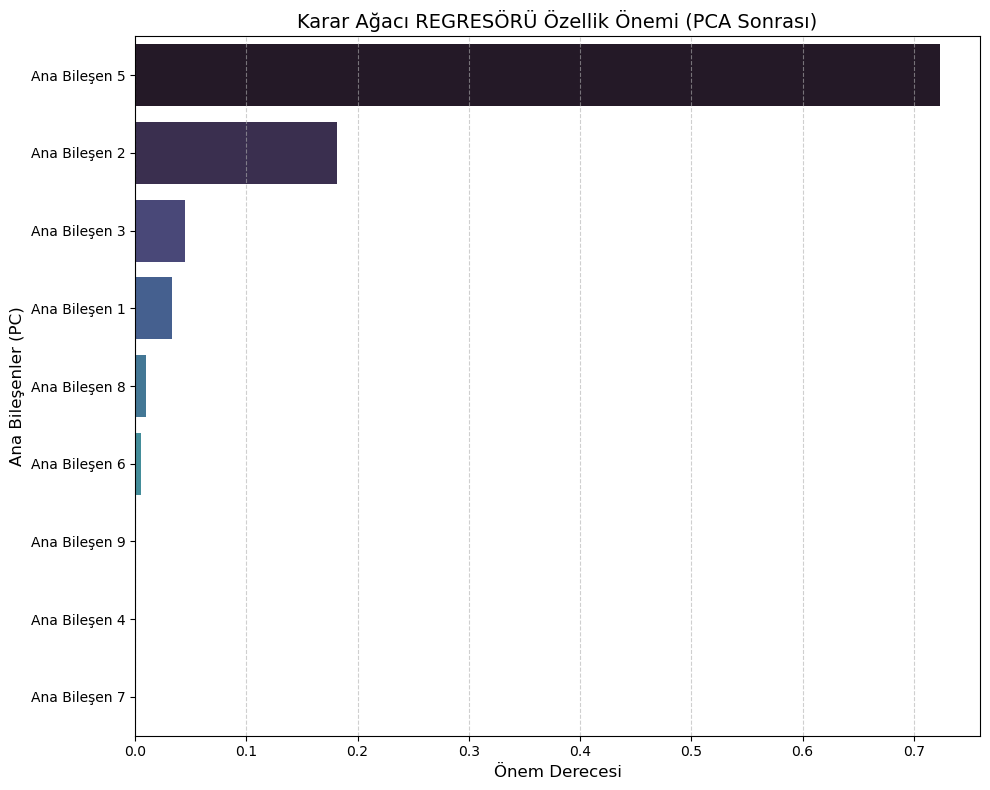


--- MODEL 2.3 SONUÇLARI (Karar Ağacı Regresörü - ORİJİNAL ÖZELLİKLER ile) ---
NOT: Bu model, PCA'dan önceki durumu görmek için PCA UYGULANMAMIŞ verilerle eğitilmiştir.
Model R-Kare (R²) Skoru: 0.0445
Model Kök Hata Kareler Ortalaması (RMSE): 4.5561

Adım (Grafik): Karar Ağacı Regresörü (Orijinal) Özellik Önemi gösteriliyor...


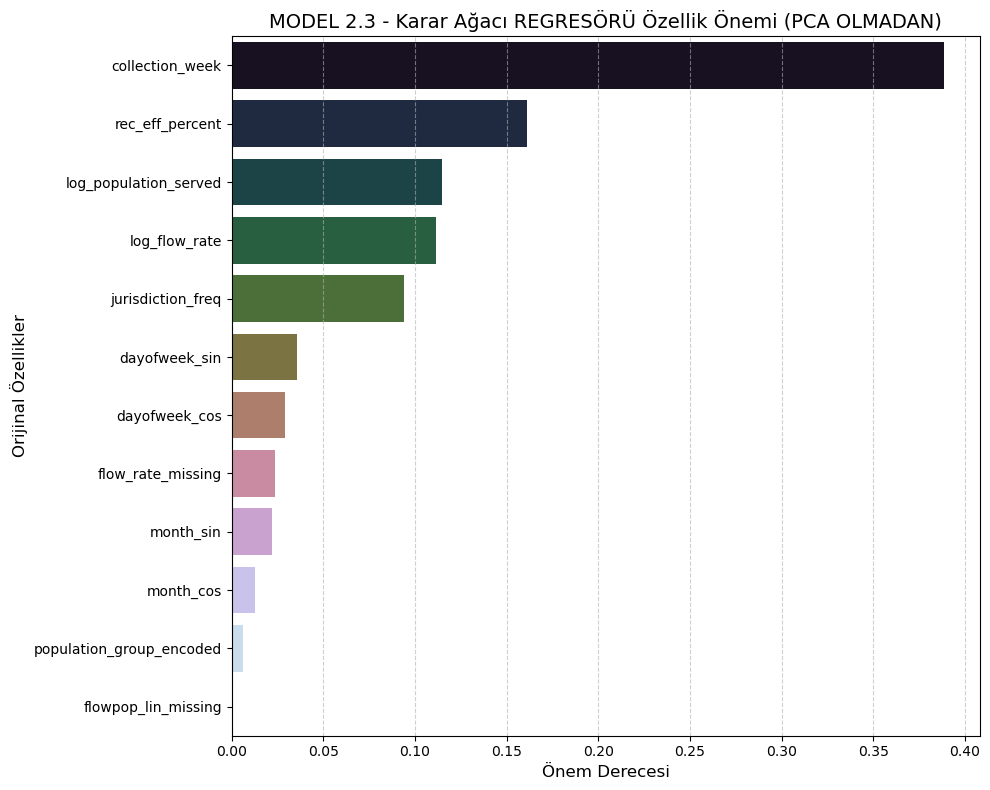


!!! Veri Bilimi Projesi (Vize) Başarıyla Tamamlandı (PCA, 2 Sınıflandırma [SGD, DT] ve 2 Regresyon [SGD, DT] Modeli Dahil) !!!
--- YENİ EKLENENLER: Model 1.3 ve 2.3 (Orijinal Özellik Önemleri) ---


In [9]:
# BÖLÜM 7: REGRESYON MODELLERİ (PCA İLE VE PCA OLMADAN)
print("\n--- BÖLÜM 2: REGRESYON MODELİ EĞİTİMİNE BAŞLANIYOR ---")
y_reg = df_model['log_pcr_target_conc']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

print("\nAdım (PCA - Regresyon): Ana Bileşen Analizi uygulanıyor...")
pca_reg = PCA(n_components=0.95, random_state=42)
X_train_reg_pca = pca_reg.fit_transform(X_train_reg_scaled)
X_test_reg_pca = pca_reg.transform(X_test_reg_scaled)
print(f"PCA (Regresyon) {X_train_reg_scaled.shape[1]} adet orijinal özelliği {pca_reg.n_components_} adet ana bileşene indirdi.")


print("\n--- MODEL 2.1 SONUÇLARI (SGD Regresörü - PCA ile) ---")
model_sgd_reg = SGDRegressor(random_state=60) 
model_sgd_reg.fit(X_train_reg_pca, y_train_reg)
y_pred_sgd_reg = model_sgd_reg.predict(X_test_reg_pca)

mse_sgd_reg = mean_squared_error(y_test_reg, y_pred_sgd_reg)
r2_sgd_reg = r2_score(y_test_reg, y_pred_sgd_reg)

print(f"Model R-Kare (R²) Skoru: {r2_sgd_reg:.4f}")
print(f"Model Kök Hata Kareler Ortalaması (RMSE): {np.sqrt(mse_sgd_reg):.4f}")


print("\n--- MODEL 2.2 SONUÇLARI (Karar Ağacı Regresörü - PCA ile) ---")
model_dtr = DecisionTreeRegressor(random_state=42, max_depth=5,min_samples_split=20)
model_dtr.fit(X_train_reg_pca, y_train_reg)
y_pred_dtr = model_dtr.predict(X_test_reg_pca)

mse_dtr = mean_squared_error(y_test_reg, y_pred_dtr)
r2_dtr = r2_score(y_test_reg, y_pred_dtr)

print(f"Model R-Kare (R²) Skoru: {r2_dtr:.4f}")
print(f"Model Kök Hata Kareler Ortalaması (RMSE): {np.sqrt(mse_dtr):.4f}")


# Karar Ağacı Regresörü Özellik Önemi Grafiği (PCA ile)
feature_names_reg_pca = [f'Ana Bileşen {i+1}' for i in range(pca_reg.n_components_)]


#PCA Bileşen Yorumlaması (Regresyon) 
print("\n--- PCA Bileşenlerinin Yorumlanması (Regresyon Modeli 2.2) ---")
print("Grafikteki 'Ana Bileşenlerin' (PC) hangi orijinal özellikleri temsil ettiğini gösteren ana yükler (loadings):")
loadings_reg = pca_reg.components_

for i, component in enumerate(feature_names_reg_pca):
    weights = loadings_reg[i]
    feature_weights = pd.Series(weights, index=features)
    # Mutlak değere göre sırala
    sorted_weights = feature_weights.abs().sort_values(ascending=False)
    # En yüksek 3 özelliği al
    top_features = sorted_weights.head(3).index
    
    print(f"\n{component}:")
    print(f"  En çok etkileyen 3 özellik: {list(top_features)}")
print("----------------------------------------------------------")



feature_importances_dtr = model_dtr.feature_importances_
importance_df_dtr = pd.DataFrame({
    'Feature': feature_names_reg_pca,
    'Importance': feature_importances_dtr
}).sort_values(by='Importance', ascending=False)

top_features_dtr = importance_df_dtr.head(pca_reg.n_components_)

plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance', y='Feature', data=top_features_dtr,
    palette='mako',
    hue='Feature', legend=False
)
plt.title('Karar Ağacı REGRESÖRÜ Özellik Önemi (PCA Sonrası)', fontsize=14)
plt.xlabel('Önem Derecesi', fontsize=12)
plt.ylabel('Ana Bileşenler (PC)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



print("\n--- MODEL 2.3 SONUÇLARI (Karar Ağacı Regresörü - ORİJİNAL ÖZELLİKLER ile) ---")
print("NOT: Bu model, PCA'dan önceki durumu görmek için PCA UYGULANMAMIŞ verilerle eğitilmiştir.")


model_dtr_original = DecisionTreeRegressor(random_state=42)
model_dtr_original.fit(X_train_reg_scaled, y_train_reg) # <-- _scaled, _pca DEĞİL
y_pred_dtr_original = model_dtr_original.predict(X_test_reg_scaled) # <-- _scaled, _pca DEĞİL

mse_dtr_original = mean_squared_error(y_test_reg, y_pred_dtr_original)
r2_dtr_original = r2_score(y_test_reg, y_pred_dtr_original)

print(f"Model R-Kare (R²) Skoru: {r2_dtr_original:.4f}")
print(f"Model Kök Hata Kareler Ortalaması (RMSE): {np.sqrt(mse_dtr_original):.4f}")

print("\nAdım (Grafik): Karar Ağacı Regresörü (Orijinal) Özellik Önemi gösteriliyor...")
feature_importances_dtr_original = model_dtr_original.feature_importances_
importance_df_dtr_original = pd.DataFrame({
    'Feature': features, # <-- Orijinal 'features' listesi
    'Importance': feature_importances_dtr_original
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance', y='Feature', data=importance_df_dtr_original,
    palette='cubehelix', # Farklı bir palet
    hue='Feature', legend=False
)
plt.title('MODEL 2.3 - Karar Ağacı REGRESÖRÜ Özellik Önemi (PCA OLMADAN)', fontsize=14)
plt.xlabel('Önem Derecesi', fontsize=12)
plt.ylabel('Orijinal Özellikler', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



print("\n!!! Veri Bilimi Projesi (Vize) Başarıyla Tamamlandı (PCA, 2 Sınıflandırma [SGD, DT] ve 2 Regresyon [SGD, DT] Modeli Dahil) !!!")
print("--- YENİ EKLENENLER: Model 1.3 ve 2.3 (Orijinal Özellik Önemleri) ---")

In [10]:
# --- SONUÇ RAPORLAMA VE KARŞILAŞTIRMA MODÜLÜ ---
print("\n" + "="*50)
print("PROJE SONUÇ RAPORU (TÜM MODELLER)")
print("="*50)

# 1. SINIFLANDIRMA (CLASSIFICATION) SONUÇLARI
# ---------------------------------------------
# Modellerin sonuçlarını bir sözlük yapısında topluyoruz
clf_results_data = {
    'Model': [
        'SGD Classifier (Model 1.1)', 
        'Decision Tree (Model 1.2)', 
        'Decision Tree (Model 1.3)', 
        'SGD Classifier (Model 1.4)'
    ],
    'Yapı': [
        'Lineer', 
        'Non-Lineer (Ağaç)', 
        'Non-Lineer (Ağaç)', 
        'Lineer'
    ],
    'Veri Tipi': [
        'PCA Uygulanmış', 
        'PCA Uygulanmış', 
        'Orijinal Özellikler', 
        'Orijinal Özellikler'
    ],
    'Accuracy (Doğruluk)': [
        accuracy_score(y_test_clf, y_pred_sgd_clf),        # 1.1
        accuracy_score(y_test_clf, y_pred_dt_clf),         # 1.2
        accuracy_score(y_test_clf, y_pred_dt_clf_original),# 1.3
        accuracy_score(y_test_clf, y_pred_sgd_clf_orig)    # 1.4
    ]
}

df_results_clf = pd.DataFrame(clf_results_data)
# Doğruluk oranına göre büyükten küçüğe sırala
df_results_clf = df_results_clf.sort_values(by='Accuracy (Doğruluk)', ascending=False)

print("\n--- TABLO 1: SINIFLANDIRMA MODELLERİ KARŞILAŞTIRMASI ---")
print(df_results_clf.to_string(index=False))


# 2. REGRESYON (REGRESSION) SONUÇLARI
# ---------------------------------------------
reg_results_data = {
    'Model': [
        'SGD Regressor (Model 2.1)', 
        'Decision Tree (Model 2.2)', 
        'Decision Tree (Model 2.3)', 
        'SGD Regressor (Model 2.4)'
    ],
    'Yapı': [
        'Lineer', 
        'Non-Lineer (Ağaç)', 
        'Non-Lineer (Ağaç)', 
        'Lineer'
    ],
    'Veri Tipi': [
        'PCA Uygulanmış', 
        'PCA Uygulanmış', 
        'Orijinal Özellikler', 
        'Orijinal Özellikler'
    ],
    'R-Kare (R2) Skoru': [
        r2_score(y_test_reg, y_pred_sgd_reg),         # 2.1
        r2_score(y_test_reg, y_pred_dtr),             # 2.2
        r2_score(y_test_reg, y_pred_dtr_original),    # 2.3
        r2_score(y_test_reg, y_pred_sgd_reg_orig)     # 2.4
    ]
}

df_results_reg = pd.DataFrame(reg_results_data)
# R2 skoruna göre büyükten küçüğe sırala
df_results_reg = df_results_reg.sort_values(by='R-Kare (R2) Skoru', ascending=False)

print("\n--- TABLO 2: REGRESYON MODELLERİ KARŞILAŞTIRMASI ---")
print(df_results_reg.to_string(index=False))

print("\n" + "="*50)
print("Analiz Tamamlandı.")


PROJE SONUÇ RAPORU (TÜM MODELLER)

--- TABLO 1: SINIFLANDIRMA MODELLERİ KARŞILAŞTIRMASI ---
                     Model              Yapı           Veri Tipi  Accuracy (Doğruluk)
SGD Classifier (Model 1.1)            Lineer      PCA Uygulanmış             0.751065
 Decision Tree (Model 1.2) Non-Lineer (Ağaç)      PCA Uygulanmış             0.749182
SGD Classifier (Model 1.4)            Lineer Orijinal Özellikler             0.747228
 Decision Tree (Model 1.3) Non-Lineer (Ağaç) Orijinal Özellikler             0.734093

--- TABLO 2: REGRESYON MODELLERİ KARŞILAŞTIRMASI ---
                    Model              Yapı           Veri Tipi  R-Kare (R2) Skoru
Decision Tree (Model 2.2) Non-Lineer (Ağaç)      PCA Uygulanmış           0.365601
SGD Regressor (Model 2.4)            Lineer Orijinal Özellikler           0.329135
SGD Regressor (Model 2.1)            Lineer      PCA Uygulanmış           0.328516
Decision Tree (Model 2.3) Non-Lineer (Ağaç) Orijinal Özellikler           0.044504

Analiz 

In [11]:
# =====================================================
# 1. VİZE SONRASI – PYTORCH KÜTÜPHANELERİ VE VERİ HAZIRLIĞI
# =====================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# --- PYTORCH DATA PREP ---

X_train_torch = torch.tensor(X_train_clf_scaled, dtype=torch.float32)
X_test_torch  = torch.tensor(X_test_clf_scaled, dtype=torch.float32)

y_train_torch = torch.tensor(y_train_clf.values, dtype=torch.float32).view(-1, 1)
y_test_torch  = torch.tensor(y_test_clf.values, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset  = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=256, shuffle=False)


In [12]:
# =====================================================
# 2. VİZE SONRASI – MODEL 3.1: WIDE & DEEP MİMARİSİ
# =====================================================

class WideAndDeep(nn.Module):
    def __init__(self, input_dim):
        super(WideAndDeep, self).__init__()

        # Wide (lineer) bileşen
        self.wide = nn.Linear(input_dim, 1)

        # Deep (çok katmanlı algılayıcı)
        self.deep = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.wide(x) + self.deep(x)


print("\n--- MODEL 3.1: Wide & Deep Classification ---")


--- MODEL 3.1: Wide & Deep Classification ---


In [13]:
# =====================================================
# 3. VİZE SONRASI – WIDE & DEEP MODEL EĞİTİMİ
# =====================================================

model_wd = WideAndDeep(input_dim=X_train_clf_scaled.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_wd.parameters(), lr=0.001)

epochs = 20
for epoch in range(epochs):
    model_wd.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model_wd(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

In [14]:
# =====================================================
# 4. VİZE SONRASI – WIDE & DEEP MODEL DEĞERLENDİRME
# =====================================================

model_wd.eval()
with torch.no_grad():
    logits = model_wd(X_test_torch)
    y_pred_wd = (torch.sigmoid(logits) > 0.5).int().numpy()

print("Accuracy:", accuracy_score(y_test_clf, y_pred_wd))
print(classification_report(y_test_clf, y_pred_wd))

Accuracy: 0.7803253219086179
              precision    recall  f1-score   support

           0       0.79      0.85      0.82     24632
           1       0.77      0.69      0.72     17849

    accuracy                           0.78     42481
   macro avg       0.78      0.77      0.77     42481
weighted avg       0.78      0.78      0.78     42481



In [15]:
# =====================================================
# 5. VİZE SONRASI – MODEL 3.2: FT-TRANSFORMER MİMARİSİ
# =====================================================

class FTTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim=64, num_heads=4):
        super().__init__()

        self.embedding = nn.Linear(input_dim, embed_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

        self.fc = nn.Sequential(
            nn.Linear(embed_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = self.transformer(x)
        x = x.squeeze(1)
        return self.fc(x)


print("\n--- MODEL 3.2: FT-Transformer (TabTransformer) ---")


--- MODEL 3.2: FT-Transformer (TabTransformer) ---


In [16]:
# =====================================================
# 6. VİZE SONRASI – FT-TRANSFORMER MODEL EĞİTİMİ
# =====================================================

model_ft = FTTransformer(input_dim=X_train_clf_scaled.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model_ft.parameters(), lr=0.001)

epochs = 20
for epoch in range(epochs):
    model_ft.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model_ft(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()


In [17]:
# =====================================================
# 7. VİZE SONRASI – FT-TRANSFORMER MODEL DEĞERLENDİRME
# =====================================================

model_ft.eval()
with torch.no_grad():
    logits = model_ft(X_test_torch)
    y_pred_ft = (torch.sigmoid(logits) > 0.5).int().numpy()

print("Accuracy:", accuracy_score(y_test_clf, y_pred_ft))
print(classification_report(y_test_clf, y_pred_ft))


Accuracy: 0.7860219862997575
              precision    recall  f1-score   support

           0       0.79      0.86      0.82     24632
           1       0.78      0.69      0.73     17849

    accuracy                           0.79     42481
   macro avg       0.78      0.77      0.78     42481
weighted avg       0.79      0.79      0.78     42481



In [18]:
# =====================================================
# 8. VİZE SONRASI – MODEL SONUÇLARININ GENEL TABLOYA EKLENMESİ
# =====================================================

clf_results_data['Model'] += ['Wide & Deep (Model 3.1)', 'FT-Transformer (Model 3.2)']
clf_results_data['Yapı'] += ['Hybrid DL', 'Transformer']
clf_results_data['Veri Tipi'] += ['Orijinal Özellikler', 'Orijinal Özellikler']
clf_results_data['Accuracy (Doğruluk)'] += [
    accuracy_score(y_test_clf, y_pred_wd),
    accuracy_score(y_test_clf, y_pred_ft)
]


--- SINIF DAĞILIMI GÖRSELLEŞTİRMESİ ---


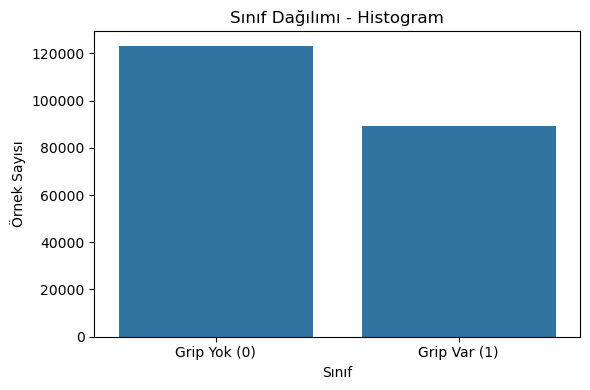

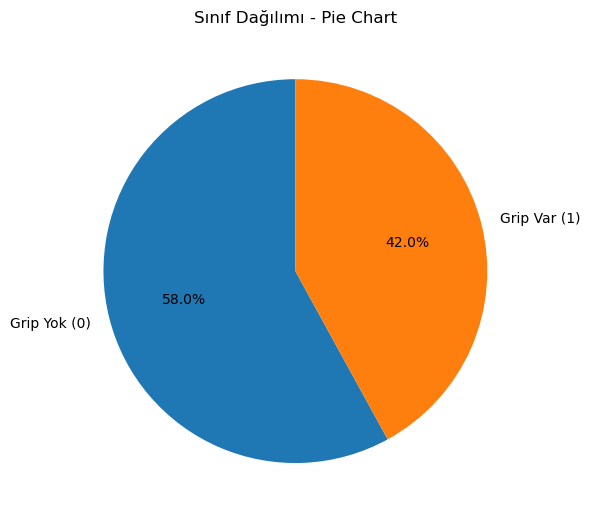

In [19]:
# =====================================================
# 9. VİZE SONRASI – SINIF DAĞILIMI GÖRSELLEŞTİRMESİ
# =====================================================

print("\n--- SINIF DAĞILIMI GÖRSELLEŞTİRMESİ ---")

class_counts = df_model['influenza_a_detected'].value_counts().sort_index()

plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks([0,1], ['Grip Yok (0)', 'Grip Var (1)'])
plt.title("Sınıf Dağılımı - Histogram")
plt.ylabel("Örnek Sayısı")
plt.xlabel("Sınıf")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
plt.pie(
    class_counts.values,
    labels=['Grip Yok (0)', 'Grip Var (1)'],
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Sınıf Dağılımı - Pie Chart")
plt.tight_layout()
plt.show()


In [20]:

# =====================================================
# 10. VİZE SONRASI – PERFORMANS METRİK FONKSİYONU
# =====================================================

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)

def compute_classification_metrics(y_true, y_pred, y_prob):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_prob)
    }

In [21]:
# =====================================================
# 11. VİZE SONRASI – BASE MODELLER OLASILIK TAHMİNLERİ
# =====================================================

y_prob_sgd = model_sgd_clf.predict_proba(X_test_clf_pca)[:,1]
y_prob_dt = model_dt_clf.predict_proba(X_test_clf_pca)[:,1]
y_prob_sgd_orig = model_sgd_clf_original.predict_proba(X_test_clf_scaled)[:,1]
y_prob_dt_orig = model_dt_clf_original.predict_proba(X_test_clf_scaled)[:,1]

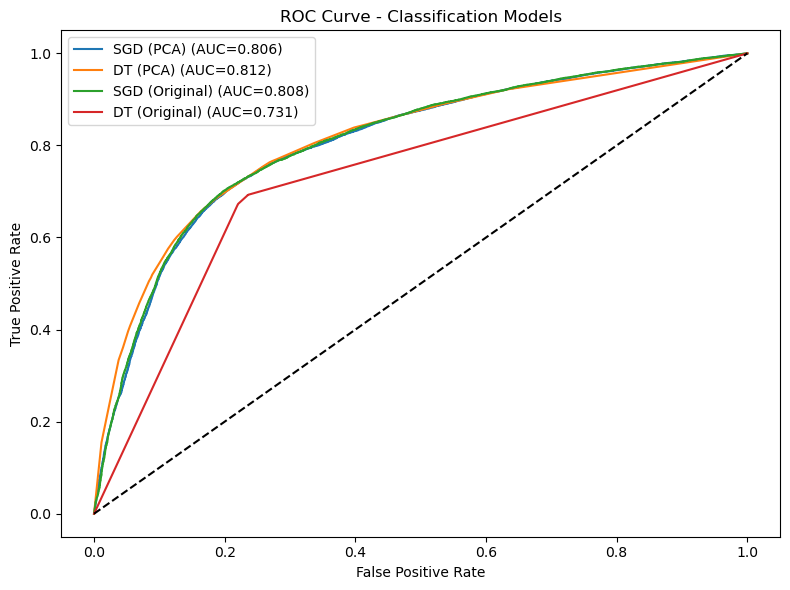

In [22]:
# =====================================================
# 12. VİZE SONRASI – BASE MODELLER ROC EĞRİLERİ
# =====================================================

plt.figure(figsize=(8,6))

models_roc = {
    'SGD (PCA)': (y_test_clf, y_prob_sgd),
    'DT (PCA)': (y_test_clf, y_prob_dt),
    'SGD (Original)': (y_test_clf, y_prob_sgd_orig),
    'DT (Original)': (y_test_clf, y_prob_dt_orig)
}

for label, (y_true, y_prob) in models_roc.items():
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = roc_auc_score(y_true, y_prob)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc_score:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Classification Models")
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
# =====================================================
# 13. VİZE SONRASI – GENEL KARŞILAŞTIRMA TABLOSU
# =====================================================

comparison_general = pd.DataFrame([
    ['SGD (PCA)', *compute_classification_metrics(
        y_test_clf, y_pred_sgd_clf, y_prob_sgd
    ).values()],
    
    ['DT (PCA)', *compute_classification_metrics(
        y_test_clf, y_pred_dt_clf, y_prob_dt
    ).values()],
    
    ['SGD (Original)', *compute_classification_metrics(
        y_test_clf, y_pred_sgd_clf_orig, y_prob_sgd_orig
    ).values()],
    
    ['DT (Original)', *compute_classification_metrics(
        y_test_clf, y_pred_dt_clf_original, y_prob_dt_orig
    ).values()]
], columns=['Model','Accuracy','Precision','Recall','F1','AUC'])

print("\n--- GENEL KARŞILAŞTIRMA TABLOSU ---")
print(comparison_general.round(4))


--- GENEL KARŞILAŞTIRMA TABLOSU ---
            Model  Accuracy  Precision  Recall      F1     AUC
0       SGD (PCA)    0.7511     0.6942  0.7284  0.7109  0.8058
1        DT (PCA)    0.7492     0.6869  0.7408  0.7128  0.8124
2  SGD (Original)    0.7472     0.6841  0.7402  0.7110  0.8078
3   DT (Original)    0.7341     0.6806  0.6917  0.6861  0.7315


In [24]:
# =====================================================
# 14. VİZE SONRASI – SINIF BAZLI BAŞARIM TABLOSU (BASE)
# =====================================================

from sklearn.metrics import classification_report

def class_based_table(y_true, y_pred, model_name):
    report = classification_report(
        y_true, y_pred, output_dict=True
    )
    df_rep = pd.DataFrame(report).T
    df_rep['Model'] = model_name
    return df_rep.loc[['0','1'], ['precision','recall','f1-score','Model']]

df_classwise = pd.concat([
    class_based_table(y_test_clf, y_pred_sgd_clf, 'SGD (PCA)'),
    class_based_table(y_test_clf, y_pred_dt_clf, 'DT (PCA)'),
    class_based_table(y_test_clf, y_pred_sgd_clf_orig, 'SGD (Original)'),
    class_based_table(y_test_clf, y_pred_dt_clf_original, 'DT (Original)')
])

print("\n--- SINIF BAZLI BAŞARIM TABLOSU ---")
print(df_classwise.round(4))



--- SINIF BAZLI BAŞARIM TABLOSU ---
   precision  recall  f1-score           Model
0     0.7959  0.7675    0.7814       SGD (PCA)
1     0.6942  0.7284    0.7109       SGD (PCA)
0     0.8008  0.7553    0.7774        DT (PCA)
1     0.6869  0.7408    0.7128        DT (PCA)
0     0.7999  0.7523    0.7754  SGD (Original)
1     0.6841  0.7402    0.7110  SGD (Original)
0     0.7740  0.7648    0.7693   DT (Original)
1     0.6806  0.6917    0.6861   DT (Original)


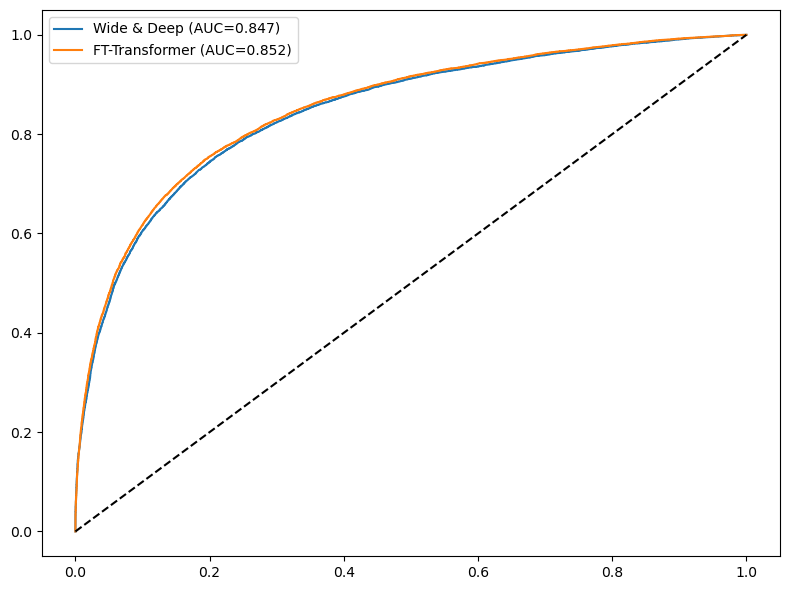

In [25]:
# =====================================================
# 15. VİZE SONRASI – ADVANCED MODELLER ROC ANALİZİ
# =====================================================

model_wd.eval()
with torch.no_grad():
    logits_wd = model_wd(X_test_torch)
    y_prob_wd = torch.sigmoid(logits_wd).cpu().numpy().ravel()

model_ft.eval()
with torch.no_grad():
    logits_ft = model_ft(X_test_torch)
    y_prob_ft = torch.sigmoid(logits_ft).cpu().numpy().ravel()

fpr_wd, tpr_wd, _ = roc_curve(y_test_clf, y_prob_wd)
auc_wd = roc_auc_score(y_test_clf, y_prob_wd)

fpr_ft, tpr_ft, _ = roc_curve(y_test_clf, y_prob_ft)
auc_ft = roc_auc_score(y_test_clf, y_prob_ft)

plt.figure(figsize=(8,6))
plt.plot(fpr_wd, tpr_wd, label=f'Wide & Deep (AUC={auc_wd:.3f})')
plt.plot(fpr_ft, tpr_ft, label=f'FT-Transformer (AUC={auc_ft:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.tight_layout()
plt.show()


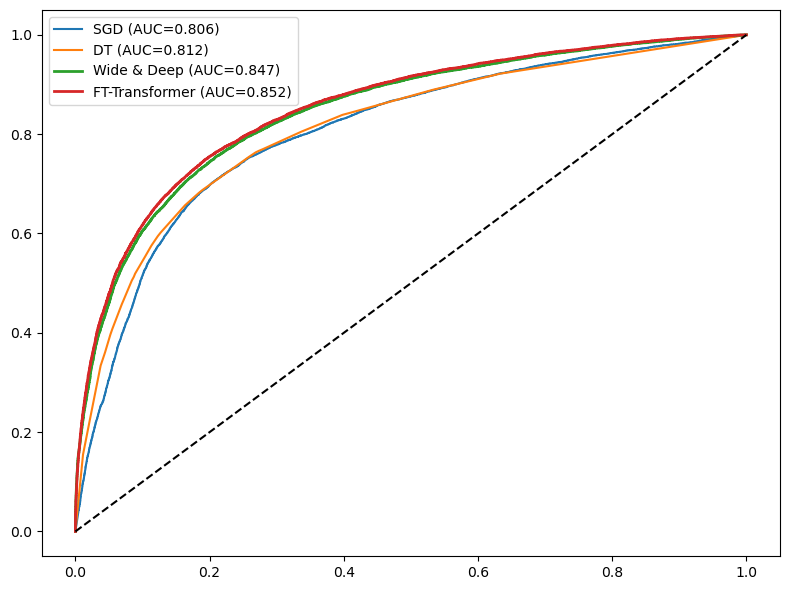

In [26]:
# =====================================================
# 16. VİZE SONRASI – TÜM MODELLER ROC KARŞILAŞTIRMASI
# =====================================================

plt.figure(figsize=(8,6))

plt.plot(*roc_curve(y_test_clf, y_prob_sgd)[:2],
         label=f'SGD (AUC={roc_auc_score(y_test_clf,y_prob_sgd):.3f})')

plt.plot(*roc_curve(y_test_clf, y_prob_dt)[:2],
         label=f'DT (AUC={roc_auc_score(y_test_clf,y_prob_dt):.3f})')

plt.plot(fpr_wd, tpr_wd,
         label=f'Wide & Deep (AUC={auc_wd:.3f})', linewidth=2)

plt.plot(fpr_ft, tpr_ft,
         label=f'FT-Transformer (AUC={auc_ft:.3f})', linewidth=2)

plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
# =====================================================
# 17. VİZE SONRASI – FINAL SINIF BAZLI KIRILIM TABLOSU
#      (BASE + ADVANCED MODELLER)
# =====================================================

y_pred_wd_cls = (y_prob_wd > 0.5).astype(int)
y_pred_ft_cls = (y_prob_ft > 0.5).astype(int)

df_classwise_final = pd.concat([
    class_based_table(y_test_clf, y_pred_sgd_clf, 'SGD (PCA)'),
    class_based_table(y_test_clf, y_pred_dt_clf, 'DT (PCA)'),
    class_based_table(y_test_clf, y_pred_sgd_clf_orig, 'SGD (Original)'),
    class_based_table(y_test_clf, y_pred_dt_clf_original, 'DT (Original)'),
    class_based_table(y_test_clf, y_pred_wd_cls, 'Wide & Deep'),
    class_based_table(y_test_clf, y_pred_ft_cls, 'FT-Transformer')
])

print("\n--- SINIF BAZLI KIRILIM TABLOSU (BASE + ADVANCED) ---")
print(df_classwise_final.round(4))



--- SINIF BAZLI KIRILIM TABLOSU (BASE + ADVANCED) ---
   precision  recall  f1-score           Model
0     0.7959  0.7675    0.7814       SGD (PCA)
1     0.6942  0.7284    0.7109       SGD (PCA)
0     0.8008  0.7553    0.7774        DT (PCA)
1     0.6869  0.7408    0.7128        DT (PCA)
0     0.7999  0.7523    0.7754  SGD (Original)
1     0.6841  0.7402    0.7110  SGD (Original)
0     0.7740  0.7648    0.7693   DT (Original)
1     0.6806  0.6917    0.6861   DT (Original)
0     0.7892  0.8476    0.8173     Wide & Deep
1     0.7657  0.6875    0.7245     Wide & Deep
0     0.7923  0.8552    0.8225  FT-Transformer
1     0.7756  0.6906    0.7306  FT-Transformer


In [28]:
import pandas as pd
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    brier_score_loss
)

# =====================================================
# MODEL + KATEGORİ HARİTASI
# =====================================================
models = {
    "SGD (PCA) [Base]": (y_pred_sgd_clf, y_prob_sgd),
    "DT (PCA) [Base]": (y_pred_dt_clf, y_prob_dt),
    "SGD (Original) [Base]": (y_pred_sgd_clf_orig, y_prob_sgd_orig),
    "DT (Original) [Base]": (y_pred_dt_clf_original, y_prob_dt_orig),
    "Wide & Deep (Tuned)": (y_pred_wd_cls, y_prob_wd),
    "FT-Transformer (Tuned)": (y_pred_ft_cls, y_prob_ft)
}

# =====================================================
# SINIF BAZLI METRİK HESAPLAMA
# =====================================================
rows = []

for model_name, (y_pred, y_prob) in models.items():

    # ---- Class 0 (Grip Yok) ----
    rows.append({
        "Model": model_name,
        "Class": "Grip Yok (0)",
        "F1 Score": f1_score(y_test_clf, y_pred, pos_label=0),
        "ROC AUC": roc_auc_score((y_test_clf == 0).astype(int), 1 - y_prob),
        "PR AUC": average_precision_score((y_test_clf == 0).astype(int), 1 - y_prob),
        "Accuracy": accuracy_score(y_test_clf, y_pred),
        "IBS (Brier)": brier_score_loss((y_test_clf == 0).astype(int), 1 - y_prob)
    })

    # ---- Class 1 (Grip Var) ----
    rows.append({
        "Model": model_name,
        "Class": "Grip Var (1)",
        "F1 Score": f1_score(y_test_clf, y_pred, pos_label=1),
        "ROC AUC": roc_auc_score(y_test_clf, y_prob),
        "PR AUC": average_precision_score(y_test_clf, y_prob),
        "Accuracy": accuracy_score(y_test_clf, y_pred),
        "IBS (Brier)": brier_score_loss(y_test_clf, y_prob)
    })

# =====================================================
# TABLO
# =====================================================
df_classwise_metrics = pd.DataFrame(rows).round(4)

print("\n--- TÜM MODELLER | KATEGORİLİ SINIF BAZLI METRİK TABLOSU ---\n")
display(df_classwise_metrics)



--- TÜM MODELLER | KATEGORİLİ SINIF BAZLI METRİK TABLOSU ---



,Model,Class,F1 Score,ROC AUC,PR AUC,Accuracy,IBS (Brier)
0,SGD (PCA) [Base],Grip Yok (0),0.7814,0.8058,0.8254,0.7511,0.1781
1,SGD (PCA) [Base],Grip Var (1),0.7109,0.8058,0.7420,0.7511,0.1781
2,DT (PCA) [Base],Grip Yok (0),0.7774,0.8124,0.8190,0.7492,0.1724
3,DT (PCA) [Base],Grip Var (1),0.7128,0.8124,0.7559,0.7492,0.1724
4,SGD (Original) [Base],Grip Yok (0),0.7754,0.8078,0.8269,0.7472,0.1774
5,SGD (Original) [Base],Grip Var (1),0.7110,0.8078,0.7435,0.7472,0.1774
6,DT (Original) [Base],Grip Yok (0),0.7693,0.7315,0.7315,0.7341,0.2613
7,DT (Original) [Base],Grip Var (1),0.6861,0.7315,0.6062,0.7341,0.2613
8,Wide & Deep (Tuned),Grip Yok (0),0.8173,0.8466,0.8645,0.7803,0.1540
9,Wide & Deep (Tuned),Grip Var (1),0.7245,0.8466,0.8152,0.7803,0.1540
